# Deep Learning Course - Exercise 1
# LeNet-5 architecture for classifying FashionMNIST

## Imports and Helper Functions

In [ ]:
%config IPCompleter.greedy=True

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# change to the paths to the correct directory
models_folder = r'/content/drive/MyDrive/Deep Learning/Deep Learning Course/ex1/saved models'
plots_folder = r'/content/drive/MyDrive/Deep Learning/Deep Learning Course/ex1/plots'

In [ ]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
# Helper functions
def plot_convergence_graph(train_acc_hist, test_acc_hist, epochs_to_plot, model_name, title_str):
  # plot results
  train_acc_hist = np.array(train_acc_hist)
  test_acc_hist = np.array(test_acc_hist)
  fig = plt.figure(figsize=(10,6))
  ax = fig.add_subplot(1,1,1)
  ax.set_title(f"Lenet5 - FashionMNIST - {title_str}\nTrain and Test Accuracy per epoch")
  ax.plot(np.arange(1, epochs_to_plot+1, 1), train_acc_hist[:epochs_to_plot], color='C0', linewidth=2)
  ax.plot(np.arange(1, epochs_to_plot+1, 1), test_acc_hist[:epochs_to_plot], color='C3', linewidth=2)
  fig.text(0.2,0.03, f'Max train acc: {100*np.max(train_acc_hist):.3f}%   Max test acc: {100*np.max(test_acc_hist):.3f}%', fontsize='x-large')
  ax.set_ylim(0.8, 1)
  ax.legend(['Train accuracy', 'Test accuracy'])
  plt.savefig(plots_folder + model_name[:-4] + '_' + str(epochs_to_plot) + '.png')
  plt.show()
  print(f'Max train acc: {100*np.max(train_acc_hist):.3f}% \t Max test acc: {100*np.max(test_acc_hist):.3f}%')

def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    # ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()  

## Dataset Loading and Preprocessing

In [ ]:
USE_VALIDATION_SET = False
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64
# percentage of training set to use as validation
if USE_VALIDATION_SET:
  valid_size = 0.2
else:
  valid_size = 0  

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
train_data = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)

# Download and load the test data
test_data = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['T-shirt/top',
           'Trouser',
           'Pullover',
           'Dress',
           'Coat',
           'Sandal',
           'Shirt',
           'Sneaker',
           'Bag',
           'Ankle Boot']

data_iter = iter(train_loader)         

## Dataset Visualization

In [ ]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img.view(28, 28).numpy().squeeze()
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(img)  # convert from Tensor image

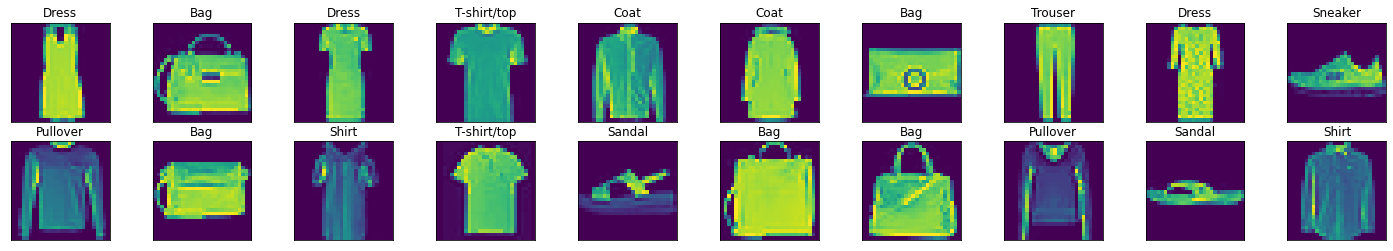

In [ ]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))

# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

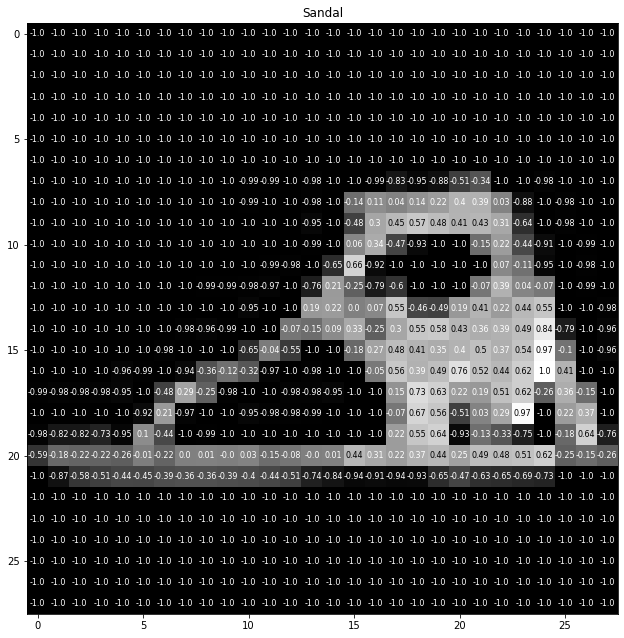

In [ ]:
# Visualize the data in more detail
idx = 40
img = images[idx]
img = img.view(28, 28).numpy()
fig = plt.figure(figsize = (36, 36)) 
ax = fig.add_subplot(1, 3, 1)
ax.imshow(img, cmap='gray')
ax.set_title(classes[labels[idx].item()])
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                horizontalalignment='center',
                verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

## Network Architecture

In [ ]:
# Network architecture

class LeNet5(nn.Module):
  def __init__(self, use_dropout=False, use_batchnorm=False):
      super().__init__()
      # optional parameters for regularization during training 
      self.use_dropout = use_dropout
      self.use_batchnorm = use_batchnorm
    
      if self.use_batchnorm is True:
        # if batch norm is used, omit the bias
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2, bias=False) # padding=2 because we use input size 28X28 and not 32X32
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, 5, bias=False)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 120, 5, bias=False)
        self.bn3 = nn.BatchNorm2d(120)
        self.fc1 = nn.Linear(120, 84, bias=False)
        self.bn4 = nn.BatchNorm1d(84)

      else:
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2) # padding=2 because we use input size 28X28 and not 32X32
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 120, 5)
        self.fc1 = nn.Linear(120, 84)
      
      self.avgpool = nn.AvgPool2d(2, 2)
      self.fc2 = nn.Linear(84, 10)
      
      if  self.use_dropout is True:
        self.dropout = nn.Dropout(0.5)
      
  def forward(self, x):
    x = self.conv1(x)
    if self.use_batchnorm:
      x = self.bn1(x)     
    x = torch.tanh(x)
   
    x = self.avgpool(x)
   
    x = self.conv2(x)
   
    if self.use_batchnorm:
      x = self.bn2(x)      
    x = torch.tanh(x)
   
    x = self.avgpool(x)
   
    x = self.conv3(x)
    if self.use_batchnorm:
      x = self.bn3(x)  
    x = torch.tanh(x)

    # flatten x before fc layer
    x = x.view(-1, 120)    
    if self.use_dropout is True:
      x = self.dropout(x)
          
    x = self.fc1(x)
    if self.use_batchnorm:
      x = self.bn4(x)
      
    x = torch.tanh(x) 
    if self.use_dropout is True:
      x = self.dropout(x)
            
    x = F.log_softmax(self.fc2(x), dim=1)
    return x

## Model Training and Testing

In [ ]:
# Train the model - (saving is commented out)
def train(model, model_name, _optimizer, _criterion, n_epochs = 100, TEST_EACH_EPOCH = True, SAVE_MODEL = False, use_dropout=False):
  # model_name = r'/lenet5_no_reg.pth' 
  train_acc_hist = []

  if TEST_EACH_EPOCH:
    test_loss_min = np.Inf
    test_loss = 0.0
    test_acc = 0.0
    test_acc_hist = []
    # for calcuating accuracy for each class separately
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

  if USE_VALIDATION_SET:
    valid_loss_min, valid_acc_hist = np.Inf, []

  model.cuda()
  for epoch in range(1, n_epochs+1):
      # initialize to zero each epoch
      train_loss, train_acc = 0.0, 0.0
      valid_loss, valid_acc = 0.0, 0.0
      test_loss, test_acc = 0.0, 0.0
          
      ###################
      # train the model #
      ###################
      model.train()
      for data, target in train_loader:
          # move tensors to gpu
          data, target = data.cuda(), target.cuda()
      
          # clear the gradients of all optimized variables
          _optimizer.zero_grad()

          output = model(data)
          loss = _criterion(output, target)
          loss.backward()
          _optimizer.step()
        
          # update training loss
          train_loss += loss.item()*data.size(0)

          # update training accuracy 
          if use_dropout: 
            model.eval()
            with torch.no_grad(): # disable gradient calculations in validation / testing
              output = model(data)
              _, pred = torch.max(output, 1)    
              correct_tensor = pred.eq(target.data.view_as(pred))
              correct = np.squeeze(correct_tensor.cpu().numpy())
              train_acc += correct.mean()*data.size(0)
            model.train()
  
          else:
            _, pred = torch.max(output, 1)    
            correct_tensor = pred.eq(target.data.view_as(pred))
            correct = np.squeeze(correct_tensor.cpu().numpy())
            train_acc += correct.mean()*data.size(0)

      # calculate average losses
      train_loss = train_loss/len(train_loader.sampler)
      # # calculate average accuracies
      train_acc = train_acc/len(train_loader.sampler)
      # update history
      train_acc_hist.append(train_acc)
      
      if TEST_EACH_EPOCH:
        ###################    
        # test the model  #
        ###################
        model.eval()
        for data, target in test_loader:
            # move tensors to gpu
            data, target = data.cuda(), target.cuda()
            with torch.no_grad(): # disable gradient calculations in validation / testing
              output = model(data)
              loss = _criterion(output, target)
              test_loss += loss.item()*data.size(0)
              
            # calculate accuracy
            _, pred = torch.max(output, 1)    
            correct_tensor = pred.eq(target.data.view_as(pred))
            correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
            test_acc += correct.mean()*data.size(0)
            
            # calculate test accuracy for each object class
            for i in range(len(target.data)):
                label = target.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

        # average test loss
        test_loss = test_loss/len(test_loader.dataset)
        test_acc = test_acc/len(test_loader.dataset)
        test_acc_hist.append(test_acc)

      if USE_VALIDATION_SET:
        ######################    
        # validate the model #
        ######################
        model.eval()
        for data, target in valid_loader:
            
            data, target = data.cuda(), target.cuda()
            with torch.no_grad(): # disable gradient calculations in validation / testing
              output = model(data)
              loss = _criterion(output, target)
              # update validation loss
              valid_loss += loss.item()*data.size(0)
              # update training accuracy
              # convert output probabilities to predicted class
              _, pred = torch.max(output, 1)    
              # compare predictions to true label
              correct_tensor = pred.eq(target.data.view_as(pred))
              correct = np.squeeze(correct_tensor.cpu().numpy())
              valid_acc += correct.mean()*data.size(0)
        valid_loss = valid_loss/len(valid_loader.sampler)
        valid_acc = valid_acc/len(valid_loader.sampler)
        valid_acc_hist.append(valid_acc)


      if USE_VALIDATION_SET:
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTraining Acc: {:.6f} \tValidation Acc: {:.6f}'.format(
            epoch, train_loss, valid_loss, train_acc, valid_acc))
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            # print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            # valid_loss_min,
            # valid_loss))
            # torch.save(model.state_dict(), models_folder + model_name)
            valid_loss_min = valid_loss
      
      elif TEST_EACH_EPOCH:
        print('Epoch: {}\tTraining Loss: {:.6f}\tTest Loss: {:.6f}\tTraining Acc: {:.6f}\tTest Acc: {:.6f}'.format(
            epoch, train_loss, test_loss, train_acc, test_acc))
        if test_loss <= test_loss_min:
            # print('Test loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            # test_loss_min,
            # test_loss))
            # torch.save(model.state_dict(), models_folder + model_name)
            test_loss_min = test_loss

      else:
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Acc: {:.6f}'.format(
            epoch, train_loss, train_acc))
        # if no validation or testing, just save each epoch
        if SAVE_MODEL:
          print('Saving model...')
          # torch.save(model.state_dict(), models_folder + model_name)
  return train_acc_hist, test_acc_hist

## LeNet-5 without regularization

In [ ]:
# create model instance
model_no_reg = LeNet5()
model_no_reg.cuda()
print(model_no_reg)

In [ ]:
# Set loss function and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model_no_reg.parameters(), lr=0.001)

In [ ]:
# Train the model
model_name = r'/lenet5_no_reg.pth'
n_epochs = 10
train_acc_hist_1, test_acc_hist_1 = train(model_no_reg, model_name, optimizer, criterion, n_epochs=n_epochs)

In [ ]:
# plot results
plot_convergence_graph(train_acc_hist_1, test_acc_hist_1, n_epochs, model_name, 'No Regularization')
# plot_convergence_graph(train_acc_hist_1, test_acc_hist_1, 10, model_name, 'No Regularization')
# plot_convergence_graph(train_acc_hist_1, test_acc_hist_1, 30, model_name, 'No Regularization')
# plot_convergence_graph(train_acc_hist_1, test_acc_hist_1, 50, model_name, 'No Regularization')
# plot_convergence_graph(train_acc_hist_1, test_acc_hist_1, 100, model_name, 'No Regularization')

## LeNet-5 with Dropout

In [ ]:
# create model instance
model_dropout = LeNet5(use_dropout=True)
model_dropout.cuda()
print(model_dropout)

In [ ]:
# Set loss function and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model_dropout.parameters(), lr=0.001)

In [ ]:
# Train the model
model_name = r'/lenet5_dropout.pth'
n_epochs = 10
train_acc_hist_2, test_acc_hist_2 = train(model_dropout, model_name, optimizer, criterion, n_epochs=n_epochs, use_dropout=True)

In [ ]:
# plot results
plot_convergence_graph(train_acc_hist_2, test_acc_hist_2, n_epochs, model_name, 'Dropout')
# plot_convergence_graph(train_acc_hist_2, test_acc_hist_2, 10, model_name, 'Dropout')
# plot_convergence_graph(train_acc_hist_2, test_acc_hist_2, 30, model_name, 'Dropout')
# plot_convergence_graph(train_acc_hist_2, test_acc_hist_2, 50, model_name, 'Dropout')
# plot_convergence_graph(train_acc_hist_2, test_acc_hist_2, 100, model_name, 'Dropout')

## LeNet-5 with Batch Normalization

In [ ]:
# create model instance
model_batchnorm = LeNet5(use_batchnorm=True)
model_batchnorm.cuda()
print(model_batchnorm)

In [ ]:
# Set loss function and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model_batchnorm.parameters(), lr=0.001)

In [ ]:
# Train the model
model_name = r'/lenet5_batchnorm.pth'
n_epochs = 10
train_acc_hist_3, test_acc_hist_3 = train(model_batchnorm, model_name, optimizer, criterion, n_epochs=n_epochs)

In [ ]:
# plot results
plot_convergence_graph(train_acc_hist_3, test_acc_hist_3, n_epochs, model_name, 'Batch Normalization')
# plot_convergence_graph(train_acc_hist_3, test_acc_hist_3, 10, model_name, 'Batch Normalization')
# plot_convergence_graph(train_acc_hist_3, test_acc_hist_3, 30, model_name, 'Batch Normalization')
# plot_convergence_graph(train_acc_hist_3, test_acc_hist_3, 50, model_name, 'Batch Normalization')
# plot_convergence_graph(train_acc_hist_3, test_acc_hist_3, 100, model_name, 'Batch Normalization')

## LeNet-5 with Weight Decay

In [ ]:
# create model instance
model_wd = LeNet5()
model_wd.cuda()
print(model_wd)

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
# Set loss function and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model_wd.parameters(), lr=0.001, weight_decay=0.001)

In [ ]:
# Train the model
model_name = r'/lenet5_wd.pth'
n_epochs = 10
train_acc_hist_4, test_acc_hist_4 = train(model_wd, model_name, optimizer, criterion, n_epochs=n_epochs)

In [ ]:
# plot results
plot_convergence_graph(train_acc_hist_4, test_acc_hist_4, n_epochs, model_name, 'Weight Decay')
# plot_convergence_graph(train_acc_hist_4, test_acc_hist_4, 10, model_name, 'Weight Decay')
# plot_convergence_graph(train_acc_hist_4, test_acc_hist_4, 30, model_name, 'Weight Decay')
# plot_convergence_graph(train_acc_hist_4, test_acc_hist_4, 50, model_name, 'Weight Decay')
# plot_convergence_graph(train_acc_hist_4, test_acc_hist_4, 100, model_name, 'Weight Decay')

## Loading and Testing Saved Models

In [ ]:
# Load the model
def load_model(model_name, models_folder, use_dropout=False, use_batchnorm=False):
  model = LeNet5(use_dropout, use_batchnorm)  
  model.load_state_dict(torch.load(models_folder + model_name))
  return model

In [ ]:
# choose the model you wish to load - make sure saved models path is correct
# change this to the correct path of ex1/saved models
models_folder = r'/content/drive/MyDrive/Deep Learning/Deep Learning Course/ex1/saved models'

model_name_batchnorm = r'/lenet5_batchnorm.pth'
model_name_dropout = r'/lenet5_dropout.pth'
model_name_no_reg = r'/lenet5_no_reg.pth'
model_name_wd = r'/lenet5_wd.pth'

# select model
model_name = model_name_batchnorm

if model_name == model_name_dropout:
  model = load_model(model_name, models_folder, use_dropout=True)
elif model_name == model_name_batchnorm:
  model = load_model(model_name, models_folder ,use_batchnorm=True)
else:
  model = load_model(model_name, models_folder)  

In [ ]:
# Test saved model

test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
test_acc = 0.0

###################    
# test the model  #
###################
model.cuda()
model.eval()

for data, target in test_loader:
    
    data, target = data.cuda(), target.cuda()
   
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    
    # calculate accuracy
    _, pred = torch.max(output, 1)    
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    test_acc += correct.mean()*data.size(0)
    

    # calculate test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
test_acc = test_acc/len(test_loader.dataset)
print('Test Loss: {:.6f} \tTest Acc: {:.6f}\n'.format(test_loss, test_acc))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            class_correct[i], class_total[i]))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2f%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.261926 	Test Acc: 0.910200

Test Accuracy of T-shirt/top: 87% (874/1000)
Test Accuracy of Trouser: 98% (983/1000)
Test Accuracy of Pullover: 83% (834/1000)
Test Accuracy of Dress: 93% (930/1000)
Test Accuracy of  Coat: 89% (898/1000)
Test Accuracy of Sandal: 97% (976/1000)
Test Accuracy of Shirt: 70% (708/1000)
Test Accuracy of Sneaker: 95% (950/1000)
Test Accuracy of   Bag: 97% (974/1000)
Test Accuracy of Ankle Boot: 97% (975/1000)

Test Accuracy (Overall): 91.020000% (9102/10000)
